In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(os.path.join(module_path, 'cnn-keras'))

In [2]:
%matplotlib inline

from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler, EarlyStopping, RemoteMonitor
from keras.utils import np_utils
import keras.backend as K
import numpy as np

import fs
import models
import utils
import plot_utils

Using Theano backend.
Using gpu device 0: Quadro K620M (CNMeM is disabled, cuDNN 5004)


In [5]:
np.random.seed(47)

DATA_DIR = '../data/imdb-wiki-tiny-dataset'

TRAIN_DATA_OBJ = 'train_data'
VAL_DATA_OBJ = 'val_data'
TEST_DATA_OBJ = 'test_data'

class_names = ['female', 'male']
n_classes = 2

shp = (3,48,48)
batch_size = 40
nb_epoch = 10
learning_rate = 1e-2
decay = 0.0
l2_reg = 1e-3

#lr_boost_epoch = 20
#lr_boost_value = 2e-2

X_train = np.load(fs.join(DATA_DIR, TRAIN_DATA_OBJ + '_00.npy')).astype(np.float32)
y_train = np.load(fs.join(DATA_DIR, TRAIN_DATA_OBJ + '_label_gender_00.npy')).astype(int)
Y_train = np_utils.to_categorical(y_train, n_classes)

X_val = np.load(fs.join(DATA_DIR, VAL_DATA_OBJ + '.npy')).astype(np.float32)
y_val = np.load(fs.join(DATA_DIR, VAL_DATA_OBJ + '_label_gender.npy')).astype(int)
Y_val = np_utils.to_categorical(y_val, n_classes)

X_test = np.load(fs.join(DATA_DIR, TEST_DATA_OBJ + '_00.npy')).astype(np.float32)
y_test = np.load(fs.join(DATA_DIR, TEST_DATA_OBJ + '_label_gender_00.npy')).astype(int)
Y_test = np_utils.to_categorical(y_test, n_classes)

class_weight = utils.get_class_weight(class_names, y_train)
print('\nUsing class weights:')
print(class_weight)
    
def flip(X):
    return X.transpose((0,3,2,1))

def transform(X, mean=None, std=None):
    if std is not None:
        return flip((flip(X) - mean) / (std + 1e-8))
    elif mean is not None:
        return flip(flip(X) - mean)
    else:
        return X

ax = (0,1,2)
mean = flip(X_train).mean(ax)
std = flip(X_train).std(ax)

X_train = transform(X_train, mean, std)
X_val = transform(X_val, mean, std)
X_test = transform(X_test, mean, std)

model = models.get_simple_cnn(
    input_shape=shp, n_classes=n_classes,
    init='glorot_normal', # Seems to be more stable than glorot uniform (Xavier Initialization)
    batch_norm=True,      # Better generalization and faster convergence, no improvements with ELU (slower computation)
    l2_reg=l2_reg,        # Adds good generalization to the model
    activation='elu',     # Seems to converge much faster instead of ReLU
    dropout=0.5,          # More generalization, drop rand connections at training time,
    fc6=512,
    fc7=512
)

print('\nUsing architecture:')
utils.get_model_shape(model, (batch_size, shp[0], shp[1], shp[2]))

# Tried also Adam and RMSProp
# However only SGD seems to be stable and converges quickly
opt = SGD(lr=learning_rate, decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

def scheduler(epoch):
    if epoch == lr_boost_epoch:
        model.optimizer.lr.set_value(lr_boost_value)
    return float(model.optimizer.lr.get_value())

# cb_change_lr = LearningRateScheduler(scheduler)
# cb_early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
# cb_remote = RemoteMonitor(root='http://localhost:9000')
# callbacks=[cb_change_lr, cb_early_stopping, cb_remote]

hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, class_weight=class_weight,
          verbose=1, validation_data=(X_val, Y_val))

score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Using class weights:
{0: 1.4962556165751373, 1: 1.0}
(40, 3, 48, 48)      :: input_3
(40, 96, 46, 46)     :: convolution2d_7
(40, 96, 46, 46)     :: batchnormalization_7
(40, 96, 46, 46)     :: activation_7
(40, 96, 23, 23)     :: maxpooling2d_7
(40, 256, 21, 21)    :: convolution2d_8
(40, 256, 21, 21)    :: batchnormalization_8
(40, 256, 21, 21)    :: activation_8
(40, 256, 10, 10)    :: maxpooling2d_8
(40, 384, 8, 8)      :: convolution2d_9
(40, 384, 8, 8)      :: batchnormalization_9
(40, 384, 8, 8)      :: activation_9
(40, 384, 4, 4)      :: maxpooling2d_9
(40, 6144)           :: flatten_3
(40, 512)            :: dense_7
(40, 512)            :: dropout_5
(40, 512)            :: dense_8
(40, 512)            :: dropout_6
(40, 2)              :: dense_9
Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 105s - loss: 2.9725 - acc: 0.5850 - val_loss: 0.7794 - val_acc: 0.5040
Epoch 2/10
10000/10000 [==============================] 

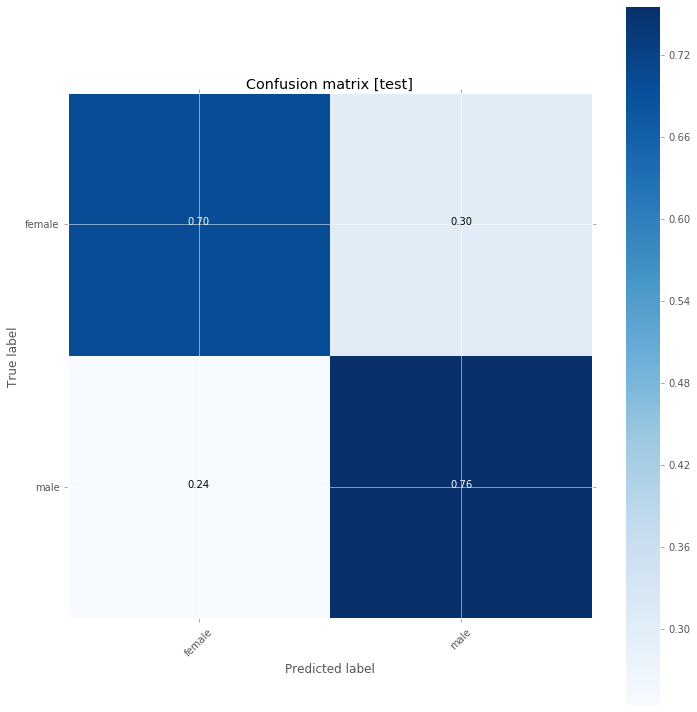

In [6]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = model.predict_classes(X_test, batch_size=batch_size, verbose=0)

cm = confusion_matrix(y_true, y_pred)

plot_utils.plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Confusion matrix [test]')

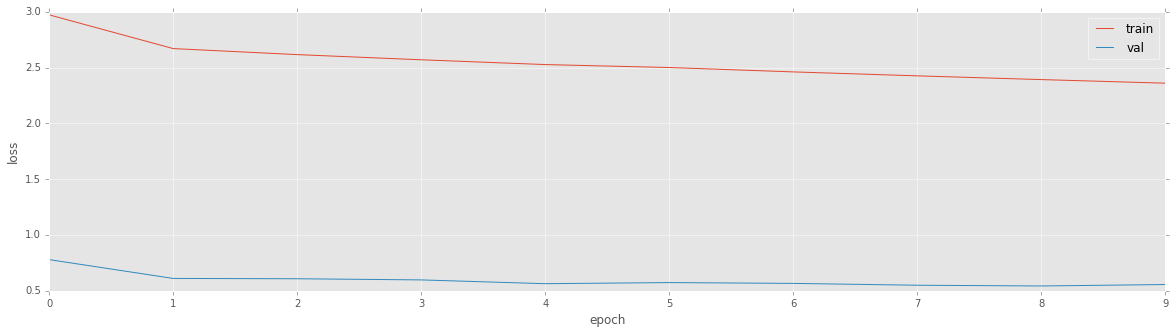

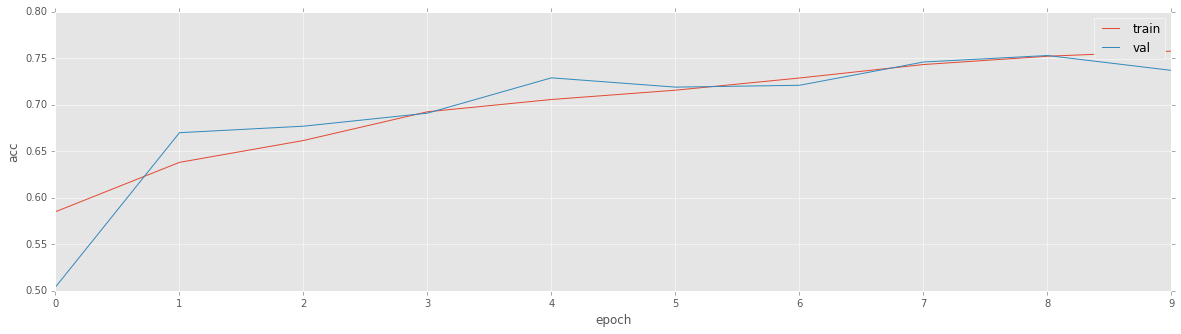

In [11]:
plot_utils.plot_perf(hist, metric='loss')
plot_utils.plot_perf(hist, metric='acc')